## Setup

Prerequisites:

In [1]:
import pandas as pd
import requests
import zipfile
from io import StringIO
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import datetime as dt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

Import test and training data:

In [2]:
start = dt.datetime.now()
df_tr = pd.read_csv("https://github.com/Galeforse/DST-Assessment-01/raw/main/Data/kd_train.csv.zip")
df_test = pd.read_csv("https://github.com/Galeforse/DST-Assessment-01/raw/main/Data/kd_test.csv.zip")
print("Data fetched in:" ,dt.datetime.now()-start)
df_tr.head()

Data fetched in: 0:00:04.368390


,Unnamed: 0,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,folds
0,44625,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1
1,339463,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1
2,321570,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1
3,355860,0,tcp,private,S0,0,0,0,0,0,...,0.06,0.07,0.0,0.0,1.0,1.0,0.0,0.0,neptune.,1
4,9708,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1


## About the Data

First we will create a data quality report on both the test and training data to get an overview of what kind of values the data contains, as well as to check for any missing data.

In [3]:
def data_qual(df):
    global data_quality_report
    #DataFrame with columns
    columns = pd.DataFrame(list(df.columns.values[1:]))

    #DataFrame with data types
    data_types = pd.DataFrame(df.dtypes, columns=['Data Type'])

    #DataFrame with Count
    data_count = pd.DataFrame(df.count(), columns=['Count'])

    #DataFrame with unique values
    unique_value_counts = pd.DataFrame(columns=['Unique Values'])
    for v in list(df.columns.values):
        unique_value_counts.loc[v] = [df[v].nunique()]

    missing_data_counts = pd.DataFrame(df.isnull().sum(), columns=['Missing Values'])
    data_quality_report = data_types.join(data_count).join(unique_value_counts).join(missing_data_counts)
    print('Data Quality Report')

In [9]:
data_qual(df_tr)
data_quality_report

Data Quality Report


,Data Type,Count,Unique Values,Missing Values
Unnamed: 0,int64,444619,444619,0
duration,int64,444619,2286,0
protocol_type,object,444619,3,0
service,object,444619,65,0
flag,object,444619,11,0
src_bytes,int64,444619,3182,0
dst_bytes,int64,444619,10278,0
land,int64,444619,2,0
wrong_fragment,int64,444619,3,0
urgent,int64,444619,3,0


In [6]:
data_qual(df_test)
data_quality_report

Data Quality Report


,Data Type,Count,Unique Values,Missing Values
Unnamed: 0,int64,49402,49402,0
duration,int64,49402,433,0
protocol_type,object,49402,3,0
service,object,49402,62,0
flag,object,49402,10,0
src_bytes,int64,49402,1243,0
dst_bytes,int64,49402,3177,0
land,int64,49402,1,0
wrong_fragment,int64,49402,3,0
urgent,int64,49402,2,0


## Overview of the attacks

We are going to count how many of each type of traffic occurs in our data, this includes all attacks as well as "normal" traffic. We use the following code to show a table representing the attacks through values, and we'll then use this data to make a quick visual representation of the types of attack in relation to each other.

In [4]:
attack = df_tr.groupby("label").size().sort_values(ascending=False)
attack = pd.DataFrame(attack)
attack.reset_index(level=0, inplace=True)
attack.columns = ['Attack','Count']
attack

,Attack,Count
0,smurf.,252590
1,neptune.,96598
2,normal.,87549
3,back.,1989
4,satan.,1436
5,ipsweep.,1100
6,portsweep.,937
7,warezclient.,917
8,teardrop.,887
9,pod.,236


Text(0.5, 1.0, 'Number of times each type of traffic is observed in the training data.')

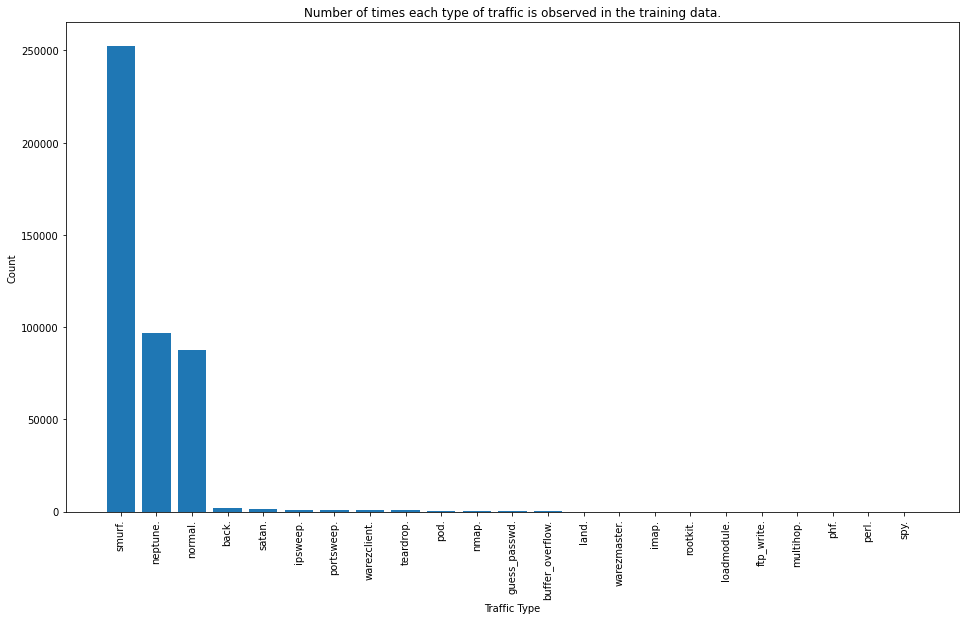

In [5]:
plt.figure(figsize=(16,9))
plt.bar(attack["Attack"],attack["Count"])
plt.xlabel("Traffic Type")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Number of times each type of traffic is observed in the training data.")

What we are most interested in in this project is the ability to predict normal vs non-normal traffic, therefore we are going to count the number of each type of traffic under the "label" column to get an impression of what kinds of attacks occur and how numerous they are in comparison to the normal traffic.

## Data Cleaning

We can see from our data quality report above that there are no missing values in any of the columns, this is good to know as we do not want missing values when we are conducting analysis. We'll also just use the following code (supplied as part of pandas) to remove any duplicate values in our data.

In [6]:
df_tr.drop_duplicates(keep='first', inplace = True)
df_test.drop_duplicates(keep='first', inplace = True)

In generating our training data we have created a folds column that is not found in the original data set and so we remove it to keep it in line with the rest of the data, and also remove the first "Unnamed" column that we has been generated in the data as this was also not present in the original data.

In [7]:
df_tr2 = df_tr.drop(["folds"],axis=1)
df_tr2 = df_tr2.drop(df_tr2.columns[0],axis=1)
df_tr2.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
1,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
2,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
3,0,tcp,private,S0,0,0,0,0,0,0,...,15,0.06,0.07,0.0,0.0,1.0,1.0,0.0,0.0,neptune.
4,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.


In [9]:
df_test2 = df_test
df_test2 = df_test2.drop(df_test2.columns[0],axis=1)
df_test2.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,private,S0,0,0,0,0,0,0,...,1,0.00,0.05,0.0,0.0,1.0,1.0,0.0,0.0,neptune.
1,0,icmp,ecr_i,SF,520,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
2,0,tcp,http,SF,186,21709,0,0,0,0,...,255,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,private,S0,0,0,0,0,0,0,...,18,0.07,0.07,0.0,0.0,1.0,1.0,0.0,0.0,neptune.
4,0,tcp,http,SF,341,6843,0,0,0,0,...,255,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,normal.


We can see from the above that smurf and neptune attacks truly dwarf the rest of the traffic, with more occurences than even that of normal traffic (neptune only just but more than double the amount of smurf attacks).

## Preparation for use with model

Further preparing data for use in a prediction model:

In [10]:
#Protocol--------------------------------------------------------------
proto = list(df_tr2["protocol_type"].values)
proto = list(set(proto))

one_hot = CountVectorizer(vocabulary=proto, binary=True)
tr_proto = one_hot.fit_transform(df_tr2["protocol_type"].values)
test_proto = one_hot.transform(df_test2["protocol_type"].values)

#Service--------------------------------------------------------------
service = list(df_tr2["service"].values)
service = list(set(service))

one_hot = CountVectorizer(vocabulary=service, binary=True)
tr_service = one_hot.fit_transform(df_tr2["service"].values)
test_service = one_hot.transform(df_test2["service"].values)

#flag--------------------------------------------------------------
flag = list(df_tr2["flag"].values)
flag = list(set(flag))

one_hot = CountVectorizer(vocabulary=flag, binary=True)
tr_flag = one_hot.fit_transform(df_tr2["flag"].values)
test_flag = one_hot.transform(df_test2["flag"].values)

In [11]:
global x
x = []
for i in attack["Attack"]:
    x.append(i)
x.remove("normal.")

In [12]:
df_tr2["label"] = df_tr2["label"].replace([x],'non-normal')
df_tr_x = df_tr2.drop(["label"],axis=1)
df_tr_y = df_tr2["label"]
df_test_x = df_test2.drop(["label"],axis=1)
df_test_y = df_test2["label"]

In [13]:
def scaling(train, test, feature_name):
    scaler = StandardScaler()
    scaler1 = scaler.fit_transform(train[feature_name].values.reshape(-1,1))
    scaler2 = scaler.transform(test[feature_name].values.reshape(-1,1))
 
    return scaler1, scaler2

In [14]:
duration1, duration2 = scaling(df_tr_x,df_test_x,"duration")
src_bytes1, src_bytes2 = scaling(df_tr_x,df_test_x,"src_bytes")
dst_bytes1, dst_bytes2 = scaling(df_tr_x,df_test_x,"dst_bytes")
land1, land2 = scaling(df_tr_x,df_test_x,"land")
wrong_fragment1, wrong_fragment2 = scaling(df_tr_x,df_test_x,"wrong_fragment")
urgent1, urgent2 = scaling(df_tr_x,df_test_x,"urgent")
hot1, hot2 = scaling(df_tr_x,df_test_x,"hot")
num_failed_logins1, num_failed_logins2 = scaling(df_tr_x,df_test_x,"num_failed_logins")
logged_in1, logged_in2 = scaling(df_tr_x,df_test_x,"logged_in")
lnum_compromised1, lnum_compromised2 = scaling(df_tr_x,df_test_x,"lnum_compromised")
lroot_shell1, lroot_shell2 = scaling(df_tr_x,df_test_x,"lroot_shell")
lsu_attempted1, lsu_attempted2 = scaling(df_tr_x,df_test_x,"lsu_attempted")
lnum_root1, lnum_root2 = scaling(df_tr_x,df_test_x,"lnum_root")
lnum_file_creations1, lnum_file_creations2 = scaling(df_tr_x,df_test_x,"lnum_file_creations")
lnum_shells1, lnum_shells2 = scaling(df_tr_x,df_test_x,"lnum_shells")
lnum_access_files1, lnum_access_files2 = scaling(df_tr_x,df_test_x,"lnum_access_files")
lnum_outbound_cmds1, lnum_outbound_cmds2 = scaling(df_tr_x,df_test_x,"lnum_outbound_cmds")
is_host_login1, is_host_login2 = scaling(df_tr_x,df_test_x,"is_host_login")
is_guest_login1, is_guest_login2 = scaling(df_tr_x,df_test_x,"is_guest_login")
count1, count2 = scaling(df_tr_x,df_test_x,"count")
srv_count1, srv_count2 = scaling(df_tr_x,df_test_x,"srv_count")
serror_rate1, serror_rate2 = scaling(df_tr_x,df_test_x,"serror_rate")
srv_serror_rate1, srv_serror_rate2 = scaling(df_tr_x,df_test_x,"srv_serror_rate")
rerror_rate1, rerror_rate2 = scaling(df_tr_x,df_test_x,"rerror_rate")
srv_rerror_rate1, srv_rerror_rate2 = scaling(df_tr_x,df_test_x,"srv_rerror_rate")
same_srv_rate1, same_srv_rate2 = scaling(df_tr_x,df_test_x,"same_srv_rate")
diff_srv_rate1, diff_srv_rate2 = scaling(df_tr_x,df_test_x,"diff_srv_rate")
srv_diff_host_rate1, srv_diff_host_rate2 = scaling(df_tr_x,df_test_x,"srv_diff_host_rate")
dst_host_count1, dst_host_count2 = scaling(df_tr_x,df_test_x,"dst_host_count")
dst_host_srv_count1, dst_host_srv_count2 = scaling(df_tr_x,df_test_x,"dst_host_srv_count")
dst_host_same_srv_rate1, dst_host_same_srv_rate2 = scaling(df_tr_x,df_test_x,"dst_host_same_srv_rate")
dst_host_diff_srv_rate1, dst_host_diff_srv_rate2 = scaling(df_tr_x,df_test_x,"dst_host_diff_srv_rate")
dst_host_same_src_port_rate1, dst_host_same_src_port_rate2 = scaling(df_tr_x,df_test_x,"dst_host_same_src_port_rate")
dst_host_srv_diff_host_rate1, dst_host_srv_diff_host_rate2 = scaling(df_tr_x,df_test_x,"dst_host_srv_diff_host_rate")
dst_host_serror_rate1, dst_host_serror_rate2 = scaling(df_tr_x,df_test_x,"dst_host_serror_rate")
dst_host_srv_serror_rate1, dst_host_srv_serror_rate2 = scaling(df_tr_x,df_test_x,"dst_host_srv_serror_rate")
dst_host_rerror_rate1, dst_host_rerror_rate2 = scaling(df_tr_x,df_test_x,"dst_host_rerror_rate")
dst_host_srv_rerror_rate1, dst_host_srv_rerror_rate2 = scaling(df_tr_x,df_test_x,"dst_host_srv_rerror_rate")

In [17]:
df_tr_xs = hstack((duration1, tr_proto, tr_service, tr_flag, src_bytes1, dst_bytes1, land1, wrong_fragment1
                    , urgent1, hot1, num_failed_logins1, logged_in1, lnum_compromised1, lroot_shell1, lsu_attempted1
                    , lnum_root1, lnum_file_creations1, lnum_shells1, lnum_access_files1, is_host_login1, is_guest_login1
                    , count1, srv_count1, serror_rate1, srv_serror_rate1, rerror_rate1, srv_rerror_rate1, same_srv_rate1
                    , diff_srv_rate1, srv_diff_host_rate1, dst_host_count1, dst_host_srv_count1, dst_host_same_srv_rate1
                    , dst_host_diff_srv_rate1, dst_host_same_src_port_rate1, dst_host_srv_diff_host_rate1
                    , dst_host_serror_rate1, dst_host_srv_serror_rate1, dst_host_rerror_rate1, dst_host_srv_rerror_rate1))
df_test_xs = hstack((duration2, test_proto, test_service, test_flag, src_bytes2, dst_bytes2, land2, wrong_fragment2
                   , urgent2, hot2, num_failed_logins2, logged_in2, lnum_compromised2, lroot_shell2, lsu_attempted2
                   , lnum_root2, lnum_file_creations2, lnum_shells2, lnum_access_files2, is_host_login2, is_guest_login2
                   , count2, srv_count2, serror_rate2, srv_serror_rate2, rerror_rate2, srv_rerror_rate2, same_srv_rate2
                   , diff_srv_rate2, srv_diff_host_rate2, dst_host_count2, dst_host_srv_count2, dst_host_same_srv_rate2
                   , dst_host_diff_srv_rate2, dst_host_same_src_port_rate2, dst_host_srv_diff_host_rate2
                   , dst_host_serror_rate2, dst_host_srv_serror_rate2, dst_host_rerror_rate2, dst_host_srv_rerror_rate2))

print(df_tr_xs.shape)
print(df_test_xs.shape)

MemoryError: Unable to allocate 3.39 MiB for an array with shape (444619, 2) and data type int32

In [21]:
LogReg = LogisticRegression(max_iter=5000)
grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}
logr_grid = GridSearchCV(LogReg, grid, cv=5)

In [ ]:
print('Fitting the model and prediction on train data:')
start = dt.datetime.now()
logr_grid.fit(df_tr_xs,df_tr_y)
y_tr_pred = logr_grid.predict(df_tr_xs)
print('Completed in:',dt.datetime.now()-start)
    
results_tr = dict()
y_tr_pred = model_name.predict(X_train)    
results_tr['precision'] = precision_score(df_tr_y, y_tr_pred, average='weighted')
results_tr['recall'] = recall_score(df_tr_y, y_tr_pred, average='weighted')
results_tr['f1_score'] = f1_score(df_tr_y, y_tr_pred, average='weighted')

Fitting the model and prediction on train data:


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## References

[KDD Dataset website with information about the data](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html)
[Medium article - Detection on the KDD Dataset](https://medium.com/analytics-vidhya/building-an-intrusion-detection-model-using-kdd-cup99-dataset-fb4cba4189ed)